**Project: License Plate Recognition**
----------------------------------
__________________________________

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

## Preprocessing and Feature Extraction

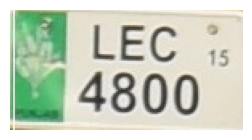

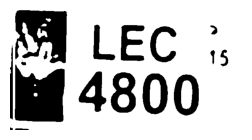

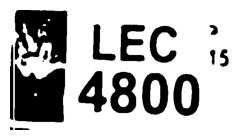

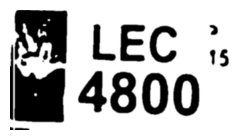

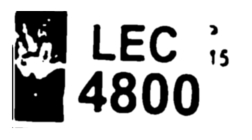

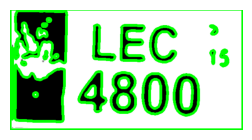

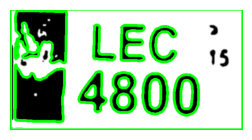

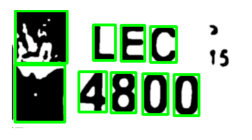

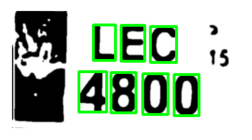

Characters Found: 7


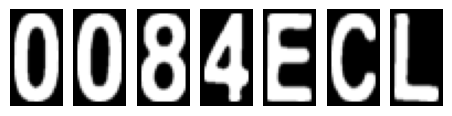

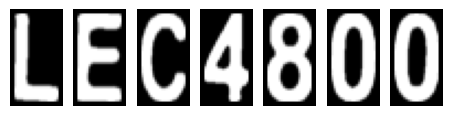

In [29]:
def sharpen(image, sigma=1.0, strength=1.5):
    blurred_image = cv2.GaussianBlur(image, (0, 0), sigma)
    unsharp_mask = cv2.addWeighted(image, 1.0 + strength, blurred_image, -strength, 0)
    unsharp_mask = np.uint8(np.clip(unsharp_mask, 0, 255))    
    return unsharp_mask

def binarythreshold(image):
    _,img_thresh = cv2.threshold(image,100,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return img_thresh

def opening(image):
    kernel = np.ones((3,3),np.uint8)
    img_erode = cv2.erode(image, kernel,iterations=2)
    img_dilate = cv2.dilate(img_erode, kernel)
    return img_dilate

def smoothen(image):
    return cv2.GaussianBlur(image, (0, 0), 1.5)

def clear_borders(image,size=5,val=255):
    n,m = np.shape(image)
    image[0:size,:] = val
    image[:,0:size] = val
    image[n-size:n,:] = val
    image[:,m-size:m] = val
    return image

def pre_proccess(image):
    #145,75 / 580,300
    image = cv2.resize(image, (580,300))
    image = binarythreshold(image)
    show(image, 'gray')
    image = opening(image)
    show(image, 'gray')
    image = smoothen(image)
    image = sharpen(image)
    show(image, 'gray')
    image = clear_borders(image)
    show(image, 'gray')
    return image

def rem_large_contours(contours, dimensions):
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    filter_factor = []; rem_indices = []
    for i,cntr in enumerate(contours):
        x,y,width,height = cv2.boundingRect(cntr)
        if (width > lower_width and width < upper_width and 
            height > lower_height and height < upper_height):
            filter_factor.append(height)
        else: rem_indices.append(i)
    cntrs = [cntr for i,cntr in enumerate(contours) if i not in rem_indices]
    return cntrs, filter_factor

def filter_contours(data, contours):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_indices = np.where((data < lower_bound) | (data > upper_bound))[0]
    filtered_data = [cntr for i,cntr in enumerate(contours) if i not in outlier_indices]
    return filtered_data

def disp_raw(image, contours):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 6)
    show(img)

# Debugging Displayer Temporary
def disp_contours(image, cntrs):
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    for cntr in cntrs:
        x,y,w,h = cv2.boundingRect(cntr)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 6)
    show(img)


def find_contours(image, dimensions):
    cntrs, _ = cv2.findContours(image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    disp_raw(image.copy(), cntrs)
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    disp_raw(image.copy(), cntrs)

    contours, filter_factor = rem_large_contours(cntrs, dimensions)
    disp_contours(image.copy(), contours)
    for cntr in contours: _,_,w,h = cv2.boundingRect(cntr)
    contours = filter_contours(filter_factor, contours)
    disp_contours(image.copy(), contours)
    print("Characters Found:",len(contours))
    return contours

def extract_chars(img, contour):
    x, y, width, height = cv2.boundingRect(contour)
    image = np.zeros((44,24))
    char = img[y:y+height, x:x+width]
    char = cv2.resize(char, (20,40))
    char = cv2.subtract(255, char)
    image[2:42,2:22] = char
    image = clear_borders(image, 2, 0)
    return image,x,y

def sort_chars(data):
    upper_row = [coords for coords in data if coords[1] < 100]
    lower_row = [coords for coords in data if coords[1] >= 100]
    # Sort each group by x-coordinate
    upper_row.sort(key=lambda coords: coords[0])
    lower_row.sort(key=lambda coords: coords[0])
    # Combine the sorted groups
    sorted_chars = upper_row + lower_row
    chars = [char for _,_,char in sorted_chars]
    return chars

def display_chars(chars):
    global i,n
    i=1
    n = len(chars)+1
    for char in chars:
        disp(char,'gray')
    plt.show()

def segment_chars(image):
    image = pre_proccess(image)
    LP_WIDTH, LP_HEIGHT = image.shape
    dimensions = [LP_WIDTH/6, LP_WIDTH/2,LP_HEIGHT/10,2*LP_HEIGHT/3]

    cntrs = find_contours(image, dimensions)
    characters = [];c=[]
    for cntr in cntrs:
        char,x,y = extract_chars(image, cntr)
        characters.append((x,y,char))
        c.append(char)
    display_chars(c)
    sorted_chars = sort_chars(characters)
    return sorted_chars

i=1;n=2
def disp(image,cmap=None):
    global i,n
    plt.subplot(1,n,i+1)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    i+=1

def show(image,cmap=None):
    plt.figure(figsize=(3,5))
    plt.imshow(image,cmap)
    plt.axis('off')
    plt.show()

n=8
filename = 'plate.jpg'
disp_img = cv2.imread(filename)
image = cv2.cvtColor(disp_img, cv2.COLOR_BGR2RGB)
show(image)

image = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
chars = segment_chars(image)
display_chars(chars)

## Sample Result

In [30]:
from tensorflow.keras.models import load_model
model = load_model('model.keras')

c:\Users\devil\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [31]:
def fix_dimension(image):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = image
    return new_img

def show_results(chars):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c
    
    output = []
    for i, ch in enumerate(chars):
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y_ = model.predict(img)
        class_ = np.argmax(y_,axis=1)[0]
        character = dic[class_]
        output.append(character)
    plate_number = str().join(output) 
    return plate_number
    
print(show_results(chars))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
LEC4800


## Feature Extraction Test

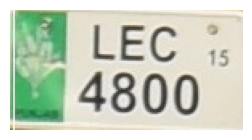

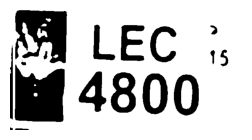

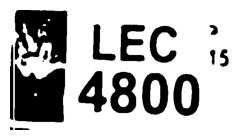

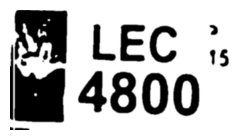

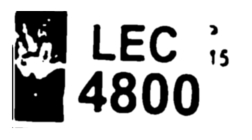

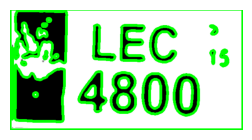

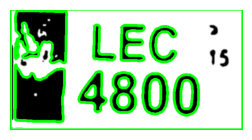

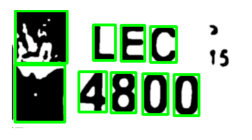

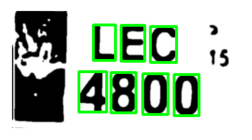

Characters Found: 7


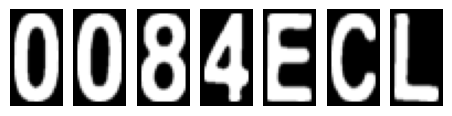

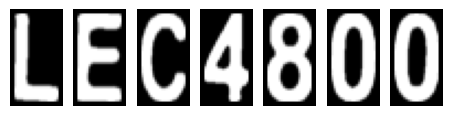

In [32]:
n=8
filename = 'plate.jpg'
disp_img = cv2.imread(filename)
image = cv2.cvtColor(disp_img, cv2.COLOR_BGR2RGB)
show(image)

image = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
chars = segment_chars(image)
display_chars(chars)

### CNN Architecture Training

In [10]:
# Attempt at Training Character Classifier
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
                    'data/train',
                    target_size=(28,28),
                    batch_size=1,
                    class_mode='categorical'
                )
validation_generator = train_datagen.flow_from_directory(
                    'data/val',
                    target_size=(28,28),
                    class_mode='categorical'
                )

Found 864 images belonging to 36 classes.


Found 216 images belonging to 36 classes.


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28,28,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=0.00001), 
              metrics=['accuracy'])

c:\Users\devil\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [22]:
class StopTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs is not None and logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.992:
            self.model.stop_training = True
            
import datetime
!rm -rf logs
log_dir = 'logs/fit/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


In [23]:
batch_size=1
callbacks= [tensorboard_callback, StopTrainingCallback()]
model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = 80, callbacks=callbacks
)

Epoch 1/80


864/864 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.0337 - loss: 3.5716 - val_accuracy: 0.2269 - val_loss: 3.4009
Epoch 2/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.2176 - val_loss: 3.3980
Epoch 3/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.1820 - loss: 3.3114 - val_accuracy: 0.4120 - val_loss: 2.8927
Epoch 4/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4398 - val_loss: 2.8823
Epoch 5/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.3238 - loss: 2.7289 - val_accuracy: 0.5509 - val_loss: 2.2768
Epoch 6/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5509 - val_loss: 2.2639
Epoch 7/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.4615 - loss: 2.1454 - val_accuracy: 0.5972 - val_loss: 1.8430
Epoch 8/80
864/864 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.0000e+00 

In [ ]:
def fix_dimension(image):
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = image
    return new_img

def show_results(chars):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c
    
    output = []
    for i, ch in enumerate(chars):
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3)
        y_ = model.predict(img)
        class_ = np.argmax(y_,axis=1)
        character = doc[class_]
        output.append(character)
    plate_number = str().join(output) 
    return plate_number
    
print(show_results(chars))